In [ ]:
# ============================================================
# SECTION 1 — PROJECT SETUP AND DATA LOADING
# ============================================================
"""
Goal:
This notebook investigates whether volatile organic compounds (VOCs)
measured in breath can differentiate high-risk (HRA) and low-risk (LRA)
individuals in the FORAGI dataset.

This first section ensures reproducibility and loads the dataset
cleanly with consistent missing-value handling.
"""

# ============================================================
# IMPORTS — Core Libraries & Dependencies
# ============================================================

# --- Core ---
import os
import random
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Statistical tests ---
from scipy.stats import mannwhitneyu

# --- Machine Learning ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    recall_score,
    precision_score,
    roc_curve,
    auc
)

# --- XGBoost ---
import xgboost as xgb
from xgboost import XGBClassifier

# --- SHAP (model interpretation) ---
!pip install shap --quiet
import shap

# Reproducibility 
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Load dataset 
filename = "/Users/qayyumayesha/bioinformatics/Scientific programming/Programming project/ABC_targeted_data/FORAGI_ABC_Compilation_AMOUNTS_AllABCTargets_BreathEquipmentAmbient_Non-imputed_Non-normalized_LinkedtoDemographics_21JUL25.xlsx"

# Make sure the file exists before reading
if not os.path.exists(filename):
    raise FileNotFoundError(f"❌ File not found at: {filename}\nPlease check the path and try again.")

# Read Excel file & treat common NA labels as missing
df = pd.read_excel(
    filename,
    engine="openpyxl",
    na_values=["n.a.", "N.A.", "NA", "na", "NaN", ""]
)

print(f" Loaded file: {filename}")
print(f"Shape: {df.shape}")

# Show a preview
df.head(3)


 Loaded file: /Users/qayyumayesha/bioinformatics/Scientific programming/Programming project/ABC_targeted_data/FORAGI_ABC_Compilation_AMOUNTS_AllABCTargets_BreathEquipmentAmbient_Non-imputed_Non-normalized_LinkedtoDemographics_21JUL25.xlsx
Shape: (440, 174)


,Seq,Label,Sample,E-CRC number,Sex,Weight,Length,English Co-morbidity,WHO ICD classification,Informal classification,...,Chromone,Indole,3-Methylindole,2-Coumaranone,2-Cyclohexylphenol,Hydroquinone,Phenalen-1-one,Benzofuran-2-yl(phenyl)methanone,Diphenylmaleic anhydride,"2,6-Diphenylphenol"
0,1,Breath,ABC00231643275309,E-CRC_MUMC_0022,1,75,173,pulmonary hypertension;asthma,MIXED: I00-I99 (Diseases of the circulatory sy...,Heart/circulation/Lung,...,0.126287,0.110289,0.094603,0.972521,0.224213,0.378588,0.167271,0.281357,0.297815,1.328503
1,1,Breath,AB203471689671209,E-CRC_MUMC_0344,0,118,183,High blood pressure;High cholesterol;Burnout,MIXED,Heart/circulation/Stress,...,0.103582,0.079161,0.088392,0.963517,0.090406,0.128813,0.135689,0.420750,1.196269,2.772950
2,1,Breath,AB202681675325449,E-CRC_MUMC_0265,1,71,167,Skin cancer (basal),L00-L99 (Diseases of the skin and subcutaneous...,Skin,...,0.068203,1.419938,0.158205,0.967715,0.163888,0.065880,0.117629,0.163844,0.123753,1.025276


In [2]:
# ============================================================
# SECTION 1B — CLEANING AND ORGANIZING RAW DATA
# ============================================================
"""
Goal:
This section standardizes labels and prepares subgroup identifiers
so that blanks and biological samples can be processed consistently.
It also calculates missingness per subgroup to evaluate data quality.
"""

# Replace Study subgroup for blanks based on Label for easier coding later on
# 'EquipmentBlank' and 'AmbientBlank' are technical control samples.
# Recode them numerically to simplify downstream filtering and grouping.
df.loc[df["Label"] == "EquipmentBlank", "Study subgroup"] = 0
df.loc[df["Label"] == "AmbientBlank", "Study subgroup"] = 1

# Remove rows where Study subgroup is "NOT FOUND"
df = df[df["Study subgroup"] != "NOT FOUND"]

# Ensure the subgroup column is numeric (important for modeling)
df["Study subgroup"] = pd.to_numeric(df["Study subgroup"], errors="coerce").astype("Int64")

# Optional: check counts
print(" Current Study subgroup counts:")
print(df["Study subgroup"].value_counts(dropna=False))


# Find metabolite columns dynamically
try:
    metabolite_start_col = df.columns.get_loc("2-Pentene, (Z)")
except KeyError:
    raise KeyError("Column '2-Pentene, (Z)' not found — check your Excel column names.")

metabolite_cols = df.columns[metabolite_start_col:]

# Keep a copy of all rows (including blanks)
df_samples = df.copy()

# And one for real samples only (subgroups 2 & 3)
real_mask = df_samples["Study subgroup"].isin([2, 3])

# Calculate missingness for real samples
missing_summary = {}
for subgroup in [2, 3]:
    subgroup_df = df_samples[df_samples["Study subgroup"] == subgroup]
    missing_count = subgroup_df[metabolite_cols].isna().sum()
    missing_percentage = subgroup_df[metabolite_cols].isna().mean() * 100
    missing_summary[subgroup] = pd.DataFrame({
        "Missing Count": missing_count,
        "Missing Percentage": missing_percentage
    })

# Display summaries
pd.set_option("display.max_rows", 20)
print("Missingness for Study Subgroup 2 (High-risk?):")
print(missing_summary[2].head(10))

print("Missingness for Study Subgroup 3 (Low-risk?):")
print(missing_summary[3].head(10))

# Save corrected file if you want 
# -----------------------------
#os.makedirs("results", exist_ok=True)
#output_path = os.path.join("results", "FORAGI_checked_blanks.xlsx")
#df.to_excel(output_path, index=False)

# print(f"Cleaned file saved at: {os.path.abspath(output_path)}")


 Current Study subgroup counts:
Study subgroup
3    121
4    115
0     74
1     72
2     54
Name: count, dtype: Int64
Missingness for Study Subgroup 2 (High-risk?):
                          Missing Count  Missing Percentage
2-Pentene, (Z)                       36           66.666667
Methoxytrimethylsilane               37           68.518519
Isoprene                              0            0.000000
3-Methyl-2-pentene_Peak1             41           75.925926
2-Ethyl-1-butene                     41           75.925926
Heptane                               0            0.000000
Carbon disulfide                      7           12.962963
Isopropenylacetylene                  7           12.962963
Dimethyl sulfide                      4            7.407407
1-Methylcyclopentene                 20           37.037037
Missingness for Study Subgroup 3 (Low-risk?):
                          Missing Count  Missing Percentage
2-Pentene, (Z)                       96           79.338843
Methoxytr

In [3]:
# ============================================================
# SECTION 2 — TRAIN/TEST SPLIT AND METADATA ORGANIZATION
# ============================================================
"""
Goal:
To prepare a clean and reproducible dataset for downstream analysis.
We first isolate real biological samples (subgroups 2 & 3),
then perform a stratified train/test split to preserve class balance.
Finally, we separate metadata from metabolite (VOC) features.
"""

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Keep only real biological samples (subgroups 2 & 3)
#
df_real = df[df["Study subgroup"].isin([2, 3])].copy()

print(f"Real samples shape: {df_real.shape}")
print(df_real["Study subgroup"].value_counts(dropna=False))


#Stratified Train/Test Split (80/20)
#Stratification ensures the class balance (HRA vs LRA) is preserved in both splits.
train_idx, test_idx = train_test_split(
    df_real.index,
    test_size=0.2,
    stratify=df_real["Study subgroup"],
    random_state=SEED
)

#Create train and test sets
df_train = df_real.loc[train_idx].copy()
df_test = df_real.loc[test_idx].copy()

print("Train size: {df_train.shape[0]}, Test size: {df_test.shape[0]}")


# Identify metadata columns
# Metadata columns include demographics and sampling info (e.g., Age, Sex, Site).
# The VOC features start from the column '2-Pentene, (Z)', located earlier
metadata_cols = df_train.columns[:metabolite_start_col]

print("Number of metadata columns: {len(metadata_cols)}")
print("Metadata columns:")
print(list(metadata_cols))


#Split metadata and VOCs
# -----------------------------
df_train_metadata = df_train[metadata_cols].copy()
df_test_metadata = df_test[metadata_cols].copy()

print("Metadata split complete.")
print(f"Train metadata shape: {df_train_metadata.shape}")
print(f"Test metadata shape: {df_test_metadata.shape}")


Real samples shape: (175, 174)
Study subgroup
3    121
2     54
Name: count, dtype: Int64
Train size: {df_train.shape[0]}, Test size: {df_test.shape[0]}
Number of metadata columns: {len(metadata_cols)}
Metadata columns:
['Seq', 'Label', 'Sample', 'E-CRC number', 'Sex', 'Weight', 'Length', 'English Co-morbidity', 'WHO ICD classification', 'Informal classification', 'Smoking status', 'Alcohol', 'Study subgroup', 'City', 'Diet', 'Age', 'Multivitamin', 'Vitamin D', 'Magnesium', 'Calcium', 'Vitamin C', 'Vitamin B', 'Omega-3', 'Other supplement']
Metadata split complete.
Train metadata shape: (140, 24)
Test metadata shape: (35, 24)


In [4]:
# ============================================================
# SECTION 3 — MISSINGNESS FILTERING AND IMPUTATION
# ============================================================
"""
Goal:
In this section we want to remove VOCs with too much missing data to ensure reliable statistical modeling and impute missing entries.
Strategy:
1. Remove features (VOCs) with >30% missing values in BOTH subgroups.
2. If a VOC is missing >30% in one subgroup :  it is retained, but that subgroup's 
   missing values are imputed using the opposite subgroup's median.
3. If a VOC is missing >30%, use the subgroup's median to impute missing entries. 
Why the median?
Because VOC values are often skewed or contain extreme outliers.
The mean can be heavily influenced by a few large measurements
The median reflects the central tendency of the majority of samples so it is more rubust.
4. Apply the same imputation logic to the test set using training medians
   (avoiding data leakage).

"""
import numpy as np
import pandas as pd

# Reproducibility 
SEED = 42
np.random.seed(SEED)

# Threshold (% missing allowed per subgroup)
threshold = 30  # max allowed % missing per subgroup
cols_to_keep = []

df_train = df_train.copy()
df_test = df_test.copy()

#Handle missingness and define 'cols_to_keep'
for col in metabolite_cols:
    # % missing per subgroup
    pct2 = df_train.loc[df_train["Study subgroup"] == 2, col].isna().mean() * 100
    pct3 = df_train.loc[df_train["Study subgroup"] == 3, col].isna().mean() * 100

    # Skip VOCs missing too much in both subgroups
    if pct2 > threshold and pct3 > threshold:
        continue

    cols_to_keep.append(col)

    # Impute using subgroup medians
    med2 = df_train.loc[df_train["Study subgroup"] == 2, col].median()
    med3 = df_train.loc[df_train["Study subgroup"] == 3, col].median()

    # Fill subgroup 2
    df_train.loc[df_train["Study subgroup"] == 2, col] = (
        df_train.loc[df_train["Study subgroup"] == 2, col]
        .fillna(med2 if pct2 <= threshold else med3)
    )

    # Fill subgroup 3
    df_train.loc[df_train["Study subgroup"] == 3, col] = (
        df_train.loc[df_train["Study subgroup"] == 3, col]
        .fillna(med3 if pct3 <= threshold else med2)
    )

#Apply same logic to test set (using train medians)
for col in cols_to_keep:
    med2 = df_train.loc[df_train["Study subgroup"] == 2, col].median()
    med3 = df_train.loc[df_train["Study subgroup"] == 3, col].median()
    for grp, med in [(2, med2), (3, med3)]:
        mask = df_test["Study subgroup"] == grp
        df_test.loc[mask, col] = df_test.loc[mask, col].fillna(med)

#Combine metadata + VOCs for modeling
df_train_vocs = df_train[cols_to_keep].copy()
df_test_vocs = df_test[cols_to_keep].copy()

X_train = pd.concat([df_train_metadata, df_train_vocs], axis=1)
X_test = pd.concat([df_test_metadata, df_test_vocs], axis=1)

y_train = df_train["Study subgroup"].astype(int)
y_test = df_test["Study subgroup"].astype(int)

# Some checks
# -----------------------------
print(f"Number of VOCs kept: {len(cols_to_keep)}")
print(f"Training samples: {len(df_train)} | Test samples: {len(df_test)}")

# Ensure alignment (no leakage)
assert X_train.index.equals(df_train.index)
assert X_test.index.equals(df_test.index)
print("Train/test data prepared correctly with no leakage or randomness.")



Number of VOCs kept: 112
Training samples: 140 | Test samples: 35
Train/test data prepared correctly with no leakage or randomness.


In [5]:
# ============================================================
# SECTION 4 — VOC Selection via Mann–Whitney U Test
# ============================================================
"""
Goal:
1. Identify VOCs that significantly differ between real biological samples (subgroups 2 & 3)
and blanks (0 = EquipmentBlank, 1 = AmbientBlank) and remove those that don't.
Why? To filter out compounds likely arising from the environment or instrument.
Why Mann–Whitney? because it is a non-parametric alternative to the t-test so it doesn't assume normality,
this is ideal for VOC intensity data, which are typically right-skewed.
Why no FDR correction? 
FDR correction was not applied because with a small sample size it would over-correct and remove true biological signals.
Also this is more "exploratory".

"""
# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)

# Step 1 — Include blanks for comparison (0 = EquipmentBlank, 1 = AmbientBlank)
df.loc[df["Label"].str.lower().str.contains("equipmentblank"), "Study subgroup"] = 0
df.loc[df["Label"].str.lower().str.contains("ambientblank"), "Study subgroup"] = 1

df_blanks = df[df["Study subgroup"].isin([0, 1])].copy()

# Combine real biological samples (2, 3) with blanks
df_train_for_test = pd.concat([df_train, df_blanks], axis=0).reset_index(drop=True)

print(f"Blanks shape: {df_blanks.shape}, Combined shape: {df_train_for_test.shape}")

#Step 2 — Select VOC columns to test
# Keep only metabolite columns present in df_train
metabolite_cols = [c for c in metabolite_cols if c in df_train.columns]

print(f"Testing {len(metabolite_cols)} VOCs for significance vs. blanks...")

# Mann–Whitney U test
significant_vocs = []
pvals = {}

for col in metabolite_cols:
    real_vals = df_train_for_test.loc[
        df_train_for_test["Study subgroup"].isin([2, 3]), col
    ].dropna()

    blank_vals = df_train_for_test.loc[
        df_train_for_test["Study subgroup"].isin([0, 1]), col
    ].dropna()

    # Skip columns with too few values
    if len(real_vals) <= 2 or len(blank_vals) <= 2:
        continue

    stat, pval = mannwhitneyu(real_vals, blank_vals, alternative="two-sided")
    pvals[col] = pval

    if pval < 0.05:
        significant_vocs.append(col)

#Filter train/test to keep only significant VOCs
df_train_filtered = pd.concat(
    [df_train[["Study subgroup"]], df_train[significant_vocs]], axis=1
)
df_test_filtered = pd.concat(
    [df_test[["Study subgroup"]], df_test[significant_vocs]], axis=1
)

print(f"Kept {len(significant_vocs)} significant VOCs out of {len(metabolite_cols)} tested.")

# Save results for inspection
#os.makedirs("results", exist_ok=True)
#output_file = os.path.join("results", "significant_VOCs_train_test.xlsx")

#with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
#    df_train_filtered.to_excel(writer, sheet_name="Train", index=False)
#    df_test_filtered.to_excel(writer, sheet_name="Test", index=False)
#    pd.DataFrame({
#        "VOC": list(pvals.keys()),
#        "p-value": list(pvals.values()),
#        "Significant (p<0.05)": [col in significant_vocs for col in pvals.keys()]
#    }).sort_values(by="p-value").to_excel(writer, sheet_name="p_values", index=False)
#    pd.DataFrame({
#        "Set": ["Train", "Test"],
#        "Remaining_VOCs": [
#            len(df_train_filtered.columns) - 1,
#            len(df_test_filtered.columns) - 1,
#        ],
#    }).to_excel(writer, sheet_name="VOC_counts", index=False)

#print(f"Significant VOC results saved to: {os.path.abspath(output_file)}")


Blanks shape: (146, 174), Combined shape: (286, 174)
Testing 150 VOCs for significance vs. blanks...
Kept 85 significant VOCs out of 150 tested.


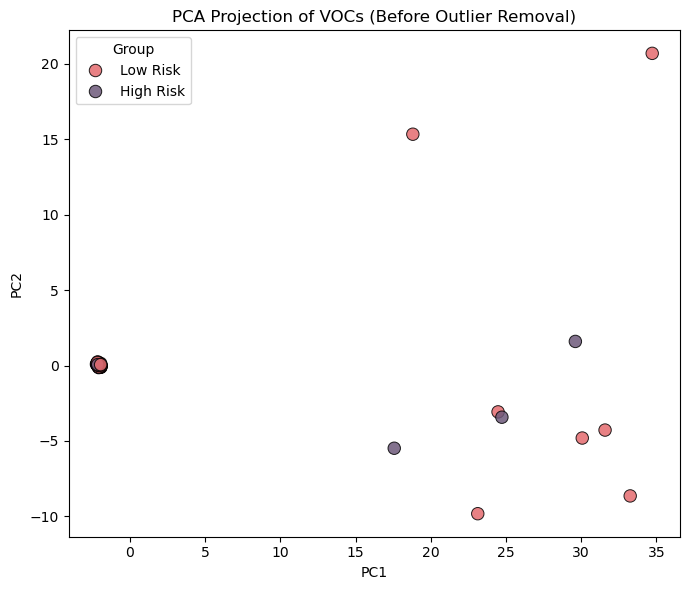

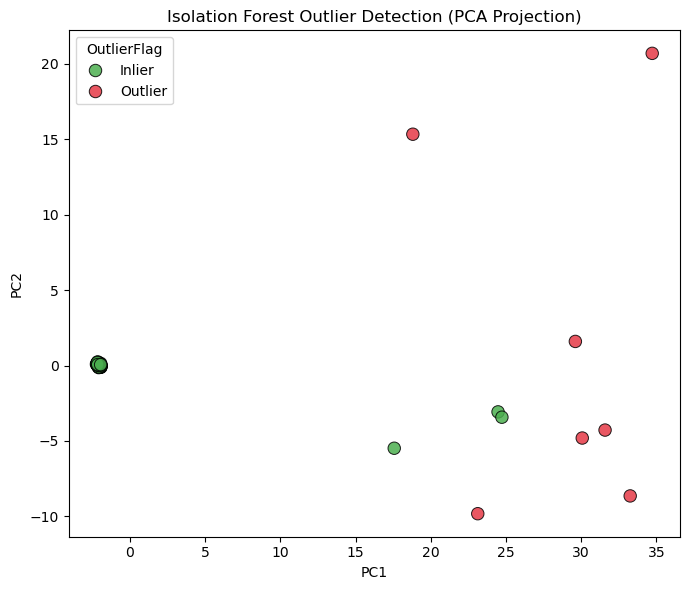

 Detected 7 potential outliers out of 140 samples.


,Study subgroup,"2-Pentene, (Z)",Isoprene,3-Methyl-2-pentene_Peak1,Heptane,Isopropenylacetylene,Dimethyl sulfide,1-Methylcyclopentene,Octane,Cyclohexene,...,p-Cresol,4-Ethylphenol,1-Docosene,2-(3-Methylphenoxy)ethanol,Indole,3-Methylindole,2-Cyclohexylphenol,Hydroquinone,"2,6-Diphenylphenol",OutlierFlag
195,3,NaN,3.232526e+07,NaN,12845.670368,39684.022126,220909.379628,NaN,14418.709895,6431.743203,...,35747.852832,35463.828469,29992.265432,6408.696695,53784.666406,4049.427076,26260.734735,44325.850193,511578.059237,Outlier
183,3,57484.759275,5.142664e+07,NaN,41093.159714,45238.684569,459622.301934,NaN,37301.401610,14788.505293,...,56235.227839,62061.494469,44456.135403,12956.583148,114797.522371,9804.264936,31260.757053,89939.249104,636974.967406,Outlier
188,2,NaN,2.035913e+07,NaN,9590.603358,18241.850826,152160.796419,NaN,17683.301486,8997.778350,...,62783.122639,81178.470413,96259.723143,60740.468014,66957.779748,5029.786010,56591.179752,113762.931861,805458.330850,Outlier
175,3,NaN,2.037063e+07,NaN,16033.129868,0.263981,81811.881891,NaN,17936.865855,21454.708396,...,112430.703224,112527.786432,218589.446859,51831.726627,82182.623463,4612.579293,50332.763803,56921.381120,474631.004836,Outlier
179,3,NaN,3.378779e+06,NaN,41149.303191,6507.318878,176992.496942,6046.837658,38596.587265,10432.453633,...,89069.584623,89468.875405,386632.021478,63826.135535,281395.563788,31965.321354,45453.778068,104929.632330,858098.524822,Outlier


In [6]:
# ============================================================
# SECTION 5b — OUTLIER DETECTION (PCA + ISOLATION FOREST)
# ============================================================
"""
Goal:
1. To identify and visualize potential outliers in the training data that may represent 
technical artefacts.
2. Use PCA for visualization 
3. Isolation Forest to identify and the remove them.
"""

# Use only VOC features for outlier detection ---
voc_train = df_train_filtered.drop(columns=["Study subgroup"]).copy()

# Handle NaNs before scaling 
voc_train = voc_train.apply(pd.to_numeric, errors="coerce")
voc_train.fillna(voc_train.mean(), inplace=True)

# Standardize features 
# (important since PCA and IsolationForest are distance-based)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(voc_train)

# PCA Visualization (before outlier removal)
pca = PCA(n_components=2, random_state=42)
pca_proj = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame({
    "PC1": pca_proj[:, 0],
    "PC2": pca_proj[:, 1],
    "Group": df_train_filtered["Study subgroup"].map({2: "High Risk", 3: "Low Risk"}).values
})

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="Group",
    palette=["#E56B6F", "#6D597A"],
    s=80, edgecolor="black", alpha=0.85
)
plt.title("PCA Projection of VOCs (Before Outlier Removal)")
plt.tight_layout()
plt.show()

# Isolation Forest
# Isolation Forest isolates anomalies by randomly partitioning data points;
# points that require fewer splits to isolate are considered outliers.
iso = IsolationForest(
    n_estimators=300,
    contamination=0.05,  # ≈5% expected outliers
    random_state=42
)

outlier_flags = iso.fit_predict(X_scaled)
df_train_filtered = df_train_filtered.copy()  # avoid SettingWithCopyWarning
df_train_filtered["OutlierFlag"] = np.where(outlier_flags == -1, "Outlier", "Inlier")

# Add to PCA DataFrame for visualization
df_pca["OutlierFlag"] = df_train_filtered["OutlierFlag"].values

# Visualize detected outliers
# -----------------------------
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="OutlierFlag",
    palette={"Inlier": "#4CAF50", "Outlier": "#E63946"},
    s=80, edgecolor="black", alpha=0.85
)
plt.title("Isolation Forest Outlier Detection (PCA Projection)")
plt.tight_layout()
plt.show()

# Summary
# -----------------------------
n_outliers = (df_train_filtered["OutlierFlag"] == "Outlier").sum()
print(f" Detected {n_outliers} potential outliers out of {len(df_train_filtered)} samples.")

# preview flagged samples
df_train_filtered[df_train_filtered["OutlierFlag"] == "Outlier"].head()


In [7]:
# ============================================================
# SECTION 5C — OUTLIER REMOVAL AND DATA CLEANUP
# ============================================================
"""
Goal:
1. Remove samples identified as statistical outliers by the Isolation Forest
to ensure that the rest of the analysis is not affected.
note: 
a. some distant samples in PCA were classified as inliers by IF but these were kept because PCA only shows two principal components
and these samples may behave normally in the full multidimensional VOC space.
b. why was IF not repeated a second time to ensure there's not more outliers? Because this check already removes the very extreme outliers,
the other ones it detects (not shown in notebook) are not as extreme as the current ones. These less extreme outliers are interesting to 
keep because they may reflect true biology (again VOC range a lot). The main goal was to remove outliers that were more likely artifacts.

"""
#remove outliers before training
df_train_filtered_no_outliers = (
    df_train_filtered[df_train_filtered["OutlierFlag"] == "Inlier"]
    .copy()
    .reset_index(drop=True)
)

print(f"Remaining after outlier removal: {df_train_filtered_no_outliers.shape[0]} samples")

#Check what proportion of samples were removed as outliers (should be close to 5%)
outlier_ratio = 1 - (len(df_train_filtered_no_outliers) / len(df_train_filtered))
print(f"🧮 Outlier ratio removed: {outlier_ratio * 100:.2f}%")

# Check subgroup balance after outlier removal
print("\nSubgroup counts after outlier removal:")
print(df_train_filtered_no_outliers["Study subgroup"].value_counts())


# Drop the flag column (because its not needed for downstream analysis)
df_train_filtered_no_outliers.drop(columns=["OutlierFlag"], inplace=True, errors="ignore")

# Use this cleaned dataset for training
df_train_filtered = df_train_filtered_no_outliers.copy()


Remaining after outlier removal: 133 samples
🧮 Outlier ratio removed: 5.00%

Subgroup counts after outlier removal:
Study subgroup
3    91
2    42
Name: count, dtype: Int64



After balancing:
Study subgroup
3.0    91
2.0    91
Name: count, dtype: int64

Accuracy (metadata + VOCs, upsampled): 82.86%

Classification Report:
              precision    recall  f1-score   support

           2       0.73      0.73      0.73        11
           3       0.88      0.88      0.88        24

    accuracy                           0.83        35
   macro avg       0.80      0.80      0.80        35
weighted avg       0.83      0.83      0.83        35



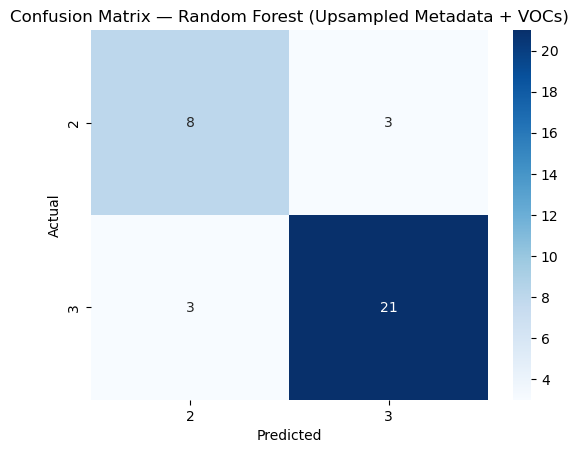

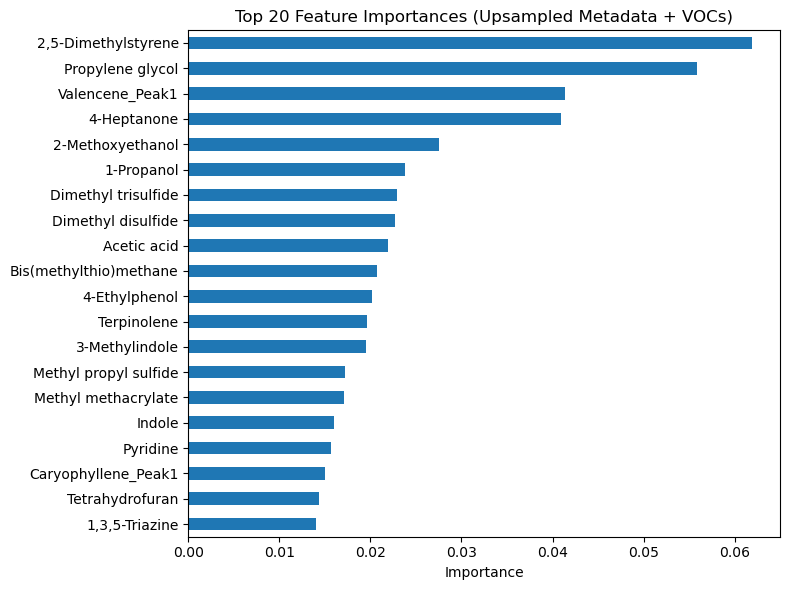

In [ ]:
# ============================================================
# SECTION 6B — RANDOM FOREST (Metadata + VOCs, Upsampled)
# ============================================================
"""
Goal:
1. Train a Random Forest model combining participant metadata and VOC features
to classify study subgroups (High-risk = 2, Low-risk = 3).
2. Upsampling is applied to balance the classes and avoid bias toward the majority group.
How? Using bootstrapping. 
Why? because its a neat way to make groups comparable, keeps the original data distribution intact and is easier than SMOTE which
synthetically generates samples and can add artificial variance.
"""


# --- Prepare data ---
df_rf_train = df_train_metadata.copy().reset_index(drop=True)
df_rf_test = df_test_metadata.copy().reset_index(drop=True)
df_train_filtered = df_train_filtered.reset_index(drop=True)
df_test_filtered = df_test_filtered.reset_index(drop=True)

# BMI does NOT exist but was computed as a measure from the Weight and Length
for df_part in [df_rf_train, df_rf_test]:
    if "BMI" not in df_part.columns:
        df_part["BMI"] = df_part.apply(
            lambda r: r["Weight"] / ((r["Length"] / 100) ** 2)
            if pd.notna(r["Weight"]) and pd.notna(r["Length"]) and r["Length"] > 0
            else np.nan,
            axis=1
        )

# Combine metadata + VOCs
# This metadata was chosen because 1)has no missing values 2)is most related to colorectal cancer 
#A safety check is included below to drop the 'OutlierFlag' column if present.
for df_part in [df_rf_train, df_rf_test, df_train_filtered, df_test_filtered]:
    if "OutlierFlag" in df_part.columns:
        df_part.drop(columns=["OutlierFlag"], inplace=True, errors="ignore")

meta_cols = ["Sex", "Weight", "Length", "BMI", "Smoking status", "Alcohol", "Age"]

X_train_combined = pd.concat(
    [df_rf_train[meta_cols], df_train_filtered.drop(columns=["Study subgroup"])],
    axis=1
)
X_test_combined = pd.concat(
    [df_rf_test[meta_cols], df_test_filtered.drop(columns=["Study subgroup"])],
    axis=1
)

# Handle missing values (normally there's none)
X_train_combined = X_train_combined.apply(pd.to_numeric, errors='coerce')
X_test_combined = X_test_combined.apply(pd.to_numeric, errors='coerce')
X_train_combined.fillna(X_train_combined.mean(), inplace=True)
X_test_combined.fillna(X_train_combined.mean(), inplace=True)

# Define target variables
y_train = df_train_filtered["Study subgroup"].astype(int)
y_test = df_test_filtered["Study subgroup"].astype(int)

train_data = pd.concat([X_train_combined, y_train], axis=1)

# Split by subgroup
train_hr = train_data[train_data["Study subgroup"] == 2]  # High-risk (minority)
train_lr = train_data[train_data["Study subgroup"] == 3]  # Low-risk (majority)

# Upsample high-risk to match low-risk
train_hr_upsampled = resample(
    train_hr,
    replace=True,
    n_samples=len(train_lr),
    random_state=42
)

#Combine and shuffle to mix both classes evenly
train_balanced = pd.concat([train_lr, train_hr_upsampled]).sample(frac=1, random_state=42)


# Separate features and labels
X_train_balanced = train_balanced.drop(columns=["Study subgroup"])
y_train_balanced = train_balanced["Study subgroup"]

print("\nAfter balancing:")
print(y_train_balanced.value_counts())


#Train Random Forest, this was tuned to avoid overffiting based on several runs (no hyperpamatre tuning though)
rf_model_combined = RandomForestClassifier(
    n_estimators=300,      # lower number to prevent overfitting
    max_depth=8,           # limit tree depth
    min_samples_leaf=5,    # force each leaf to have at least 5 samples
    max_features='sqrt',   # add randomness to feature selection
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

rf_model_combined.fit(X_train_balanced, y_train_balanced)



#Evaluate on test set

y_pred = rf_model_combined.predict(X_test_combined)
print(f"\nAccuracy (metadata + VOCs, upsampled): {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix — Random Forest (Upsampled Metadata + VOCs)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Feature Importances
importances = pd.Series(rf_model_combined.feature_importances_, index=X_train_balanced.columns)
top20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 6))
top20.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Upsampled Metadata + VOCs)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


🌲 OOB Accuracy: 89.56%
📊 CV Accuracy: 89.56% ± 3.58%

 Detailed Performance Metrics (Test Set):
Sensitivity (Recall for High-Risk): 0.875
Specificity (Recall for Low-Risk): 0.727
Precision (High-Risk): 0.727
Recall (High-Risk): 0.727


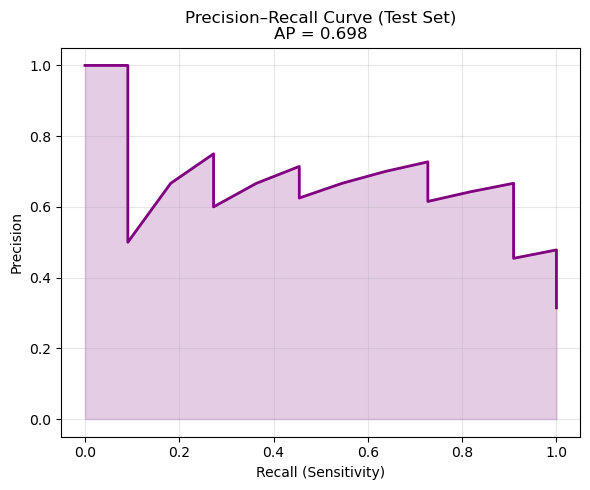

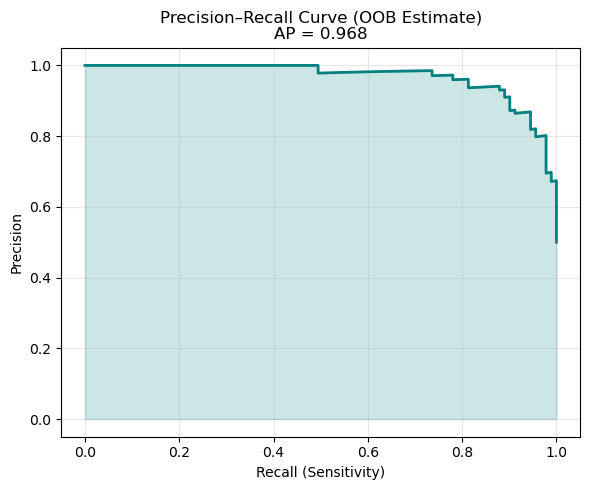

In [ ]:
# ============================================================
# SECTION 7 — MODEL EVALUATION (Random Forest)
# ============================================================
"""
Goal:
1. To rigorously evaluate model performance using both internal validation
(OOB score and cross-validation) and external validation (test set metrics).
Why ? 
a. OOB is an internal validation in RF that uses the out of bag samples (samples not used by a tree during training) to test
how well that tree predicts those. Its a way to evaluate the model without needing a seperate Cross validation. Of course, the results
will be better than test because the data distribution stays the same as the training data.
b. Cross validation is also used to further evaluate model performance. Ideally, the OOB, CV and test accuracy scores should not be too far 
off or it could suggest over or under fitting. 
2. Reported metrics : sensitivity, specificity, and precision-recall performance
"""
# OOB Accuracy
if hasattr(rf_model_combined, "oob_score_"):
    print(f"OOB Accuracy: {rf_model_combined.oob_score_ * 100:.2f}%")

# Cross-validation Accuracy (5 folds)
cv_scores = cross_val_score(rf_model_combined, X_train_balanced, y_train_balanced, cv=5)
print(f"CV Accuracy: {cv_scores.mean() * 100:.2f}% ± {cv_scores.std() * 100:.2f}%")

#Sensitivity, Specificity, and Precision–Recall Curve

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[2, 3])
tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (np.nan, np.nan, np.nan, np.nan)

# Compute metrics 
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan  # Recall for HR
specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan  # Recall for LR
precision = precision_score(y_test, y_pred, pos_label=2)
recall = recall_score(y_test, y_pred, pos_label=2)

print("\n Detailed Performance Metrics (Test Set):")
print(f"Sensitivity (Recall for High-Risk): {sensitivity:.3f}")
print(f"Specificity (Recall for Low-Risk): {specificity:.3f}")
print(f"Precision (High-Risk): {precision:.3f}")
print(f"Recall (High-Risk): {recall:.3f}")

# Precision–Recall curve (for test set) 
y_score = rf_model_combined.predict_proba(X_test_combined)[:, list(rf_model_combined.classes_).index(2)]
prec, rec, _ = precision_recall_curve(y_test, y_score, pos_label=2)
ap = average_precision_score(y_test, y_score, pos_label=2)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec, color="purple", linewidth=2)
plt.fill_between(rec, prec, alpha=0.2, color="purple")
plt.title(f"Precision–Recall Curve (Test Set)\nAP = {ap:.3f}")
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#OOB Precision–Recall Estimate
if hasattr(rf_model_combined, "oob_decision_function_"):
    try:
        y_score_oob = rf_model_combined.oob_decision_function_[:, list(rf_model_combined.classes_).index(2)]
        prec_oob, rec_oob, _ = precision_recall_curve(y_train_balanced, y_score_oob, pos_label=2)
        ap_oob = average_precision_score(y_train_balanced, y_score_oob, pos_label=2)
        
        plt.figure(figsize=(6, 5))
        plt.plot(rec_oob, prec_oob, color="teal", linewidth=2)
        plt.fill_between(rec_oob, prec_oob, alpha=0.2, color="teal")
        plt.title(f"Precision–Recall Curve (OOB Estimate)\nAP = {ap_oob:.3f}")
        plt.xlabel("Recall (Sensitivity)")
        plt.ylabel("Precision")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not compute OOB PR curve: {e}")


Global random seeds fixed for reproducibility.
Train shape: (182, 92), Test shape: (35, 92)
Label distribution (train):
Study subgroup
0.0    91
1.0    91
Name: count, dtype: int64
XGBoost model trained successfully.

 Test Accuracy: 88.57%
               precision    recall  f1-score   support

 Low-risk (0)      0.885     0.958     0.920        24
High-risk (1)      0.889     0.727     0.800        11

     accuracy                          0.886        35
    macro avg      0.887     0.843     0.860        35
 weighted avg      0.886     0.886     0.882        35



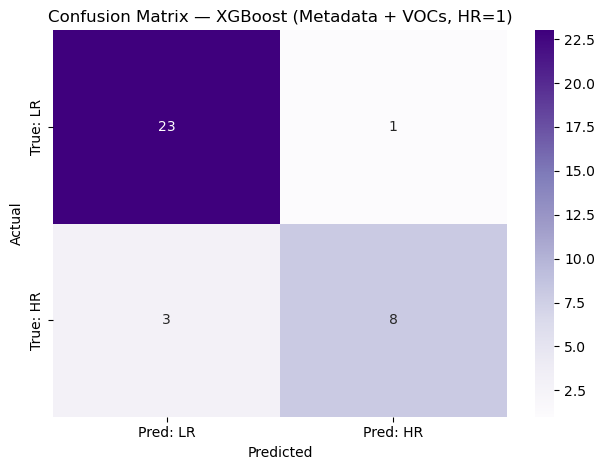


 Detailed Performance Metrics (Test Set):
Sensitivity (Recall for High-Risk): 0.727
Specificity (Recall for Low-Risk): 0.958
Precision (High-Risk): 0.889
Recall (High-Risk): 0.727


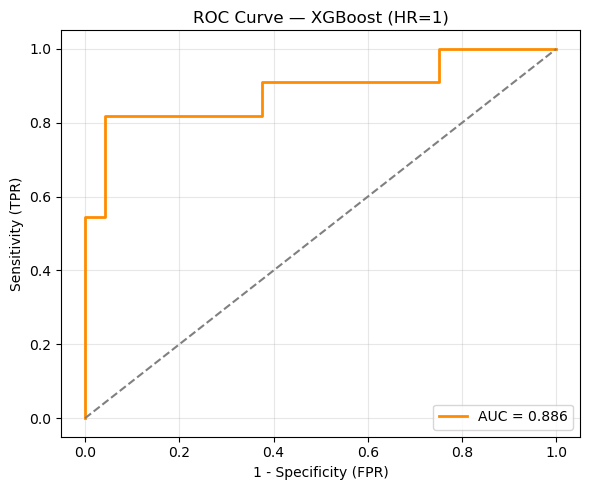

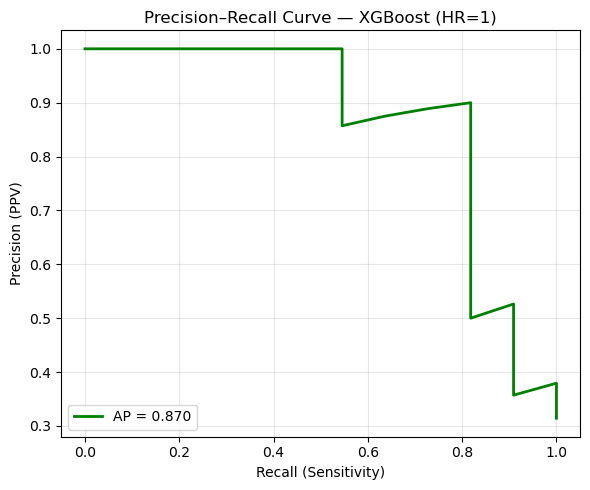

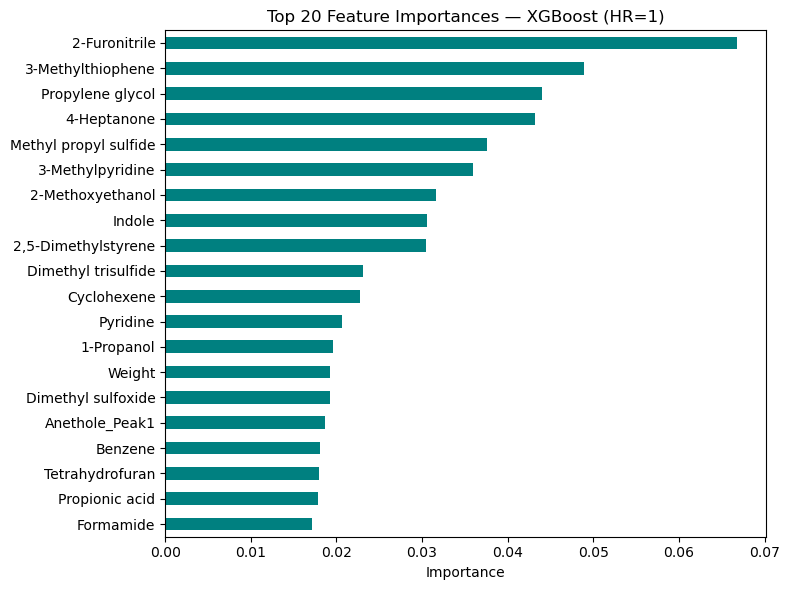

🏆 Top 20 features saved to results/top20_features_xgboost.csv


In [ ]:
# ============================================================
# SECTION 8 — XGBOOST CLASSIFIER (Metadata + VOCs)
# ============================================================
"""
Goal:
1. Train and evaluate a reproducible XGBoost model using both metadata and VOC features
to classify participants as High-risk (1) or Low-risk (0).
2. Parametre choices : These parameters were chosen to make the model stable, interpretable, and reproducible.
A lower learning rate and moderate depth was used to reduce overfitting, 
stochastic sampling was desabled (subsample=1.0, colsample_bytree=1.0) to ensure that repeated runs yield identical results.
3. Parallel computing: n_jobs = 1 was used because it uses the same model in every run. 
if n_jobs > 1 was used then it would be faster and use parallel threads but not always reproducible (the exact results) 
cause the combining of results could happen in a different order each time leading to different resutls.

Why XGBoost?
It’s a gradient boosting algorithm that builds decision trees sequentially,
each correcting errors made by the previous one. It’s generally more powerful and less biased
than standard Random Forests.

Key additions:
1. Full reproducibility (fixed seeds, single-threaded).
2. Deterministic configuration (no random sampling).
3. Binary classification setup with HR=1 and LR=0.

"""

# GLOBAL REPRODUCIBILITY LOCK
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
xgb.set_config(verbosity=0)

print("Global random seeds fixed for reproducibility.")

#Prepare Data
X_train_xgb = X_train_balanced.copy(deep=True)
X_test_xgb = X_test_combined.copy(deep=True)
y_train_xgb = y_train_balanced.copy(deep=True)
y_test_xgb = y_test.copy(deep=True)

# Recode classes: 2 = High-risk → 1, 3 = Low-risk → 0
y_train_xgb = y_train_xgb.replace({2: 1, 3: 0})
y_test_xgb = y_test_xgb.replace({2: 1, 3: 0})

print(f"Train shape: {X_train_xgb.shape}, Test shape: {X_test_xgb.shape}")
print("Label distribution (train):")
print(y_train_xgb.value_counts())

#Train XGBoost (deterministic setup)
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=1.0,            # full sampling for reproducibility
    colsample_bytree=1.0,     # full column sampling
    random_state=SEED,
    scale_pos_weight=1,
    eval_metric="logloss",
    objective="binary:logistic",
    use_label_encoder=False,
    n_jobs=1                  # single-thread for fully deterministic results
)

xgb_model.fit(X_train_xgb, y_train_xgb)
print("XGBoost model trained successfully.")

#Evaluate
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_proba_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

acc = accuracy_score(y_test_xgb, y_pred_xgb)
print(f"\n Test Accuracy: {acc*100:.2f}%")
print(classification_report(
    y_test_xgb, y_pred_xgb,
    target_names=["Low-risk (0)", "High-risk (1)"],
    digits=3
))

# Confusion Matrix
cm = confusion_matrix(y_test_xgb, y_pred_xgb, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Pred: LR", "Pred: HR"],
            yticklabels=["True: LR", "True: HR"])
plt.title("Confusion Matrix — XGBoost (Metadata + VOCs, HR=1)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#Metrics & Curves
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
precision_val = precision_score(y_test_xgb, y_pred_xgb)
recall_val = recall_score(y_test_xgb, y_pred_xgb)

print("\n Detailed Performance Metrics (Test Set):")
print(f"Sensitivity (Recall for High-Risk): {sensitivity:.3f}")
print(f"Specificity (Recall for Low-Risk): {specificity:.3f}")
print(f"Precision (High-Risk): {precision_val:.3f}")
print(f"Recall (High-Risk): {recall_val:.3f}")

#  ROC Curve 
fpr, tpr, _ = roc_curve(y_test_xgb, y_proba_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("1 - Specificity (FPR)")
plt.ylabel("Sensitivity (TPR)")
plt.title("ROC Curve — XGBoost (HR=1)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#Precision–Recall Curve 
precision_vals, recall_vals, _ = precision_recall_curve(y_test_xgb, y_proba_xgb)
avg_prec = average_precision_score(y_test_xgb, y_proba_xgb)

plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, color="green", lw=2, label=f"AP = {avg_prec:.3f}")
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision–Recall Curve — XGBoost (HR=1)")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#Feature Importances
importances = pd.Series(xgb_model.feature_importances_, index=X_train_xgb.columns)
top20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 6))
top20.plot(kind="barh", color="teal")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances — XGBoost (HR=1)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

os.makedirs("results", exist_ok=True)
top20.to_csv("results/top20_features_xgboost.csv", header=["Importance"])
print("Top 20 features saved to results/top20_features_xgboost.csv")


In [ ]:
# ============================================================
# SECTION 8B — MODEL EVALUATION (Cross-Validation for XGBoost)
# ============================================================
"""
Goal:
1. To evaluate the internal consistency of the XGBoost model using stratified 5-fold cross-validation.
2. Why StratifiedKFold?
   It ensures each fold preserves the same proportion of High-risk and Low-risk samples,
   which is crucial for imbalanced biomedical datasets.
3. Why cross-validation here?
   Unlike Random Forest, XGBoost does not have an OOB (Out-of-Bag) estimate.
   Therefore, cross-validation provides a robust internal validation measure
   to assess model stability and potential overfitting.
"""

# Cross-validation setup (5-fold, stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = cross_val_score(
    xgb_model, X_train_xgb, y_train_xgb,
    cv=cv, scoring='accuracy', n_jobs=1
)

print(f"\nCross-Validation Accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")



Cross-Validation Accuracy: 90.65% ± 5.40%



 Running SHAP for Random Forest...
RF classes: [2. 3.]
Recoding SHAP direction so positive = High-risk (class 2).


/var/folders/cd/2pthfxks1cv32d9l420hs0_c0000gn/T/ipykernel_2626/1950736408.py:59: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values_rf, X_test_for_shap, show=False)


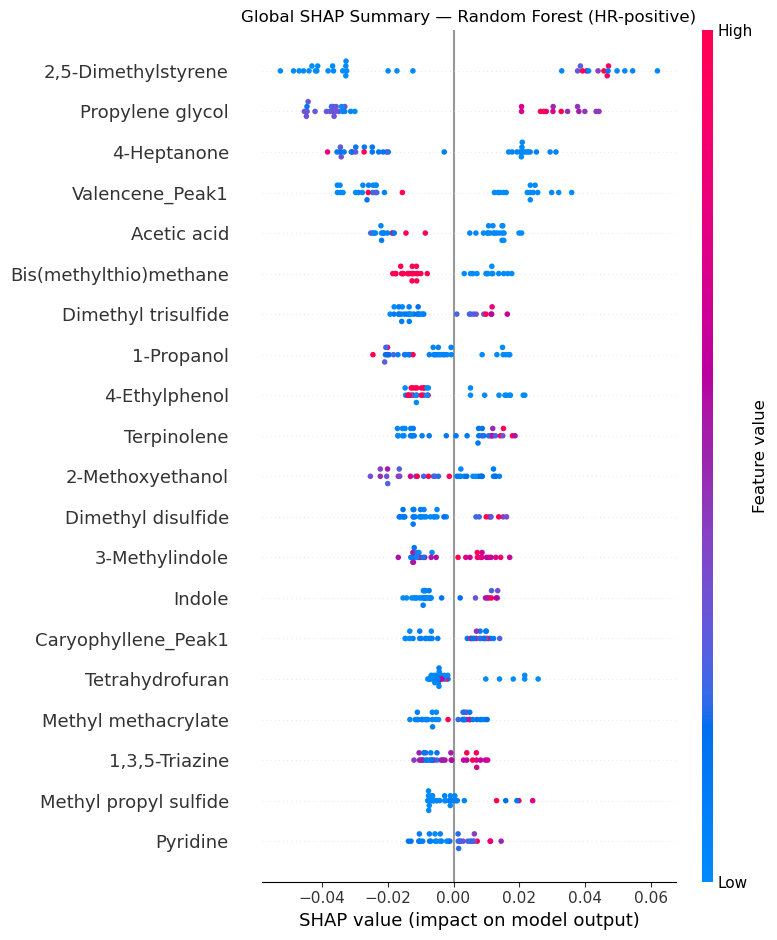

/var/folders/cd/2pthfxks1cv32d9l420hs0_c0000gn/T/ipykernel_2626/1950736408.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(values_rf, X_test_for_shap, plot_type="bar", show=False)


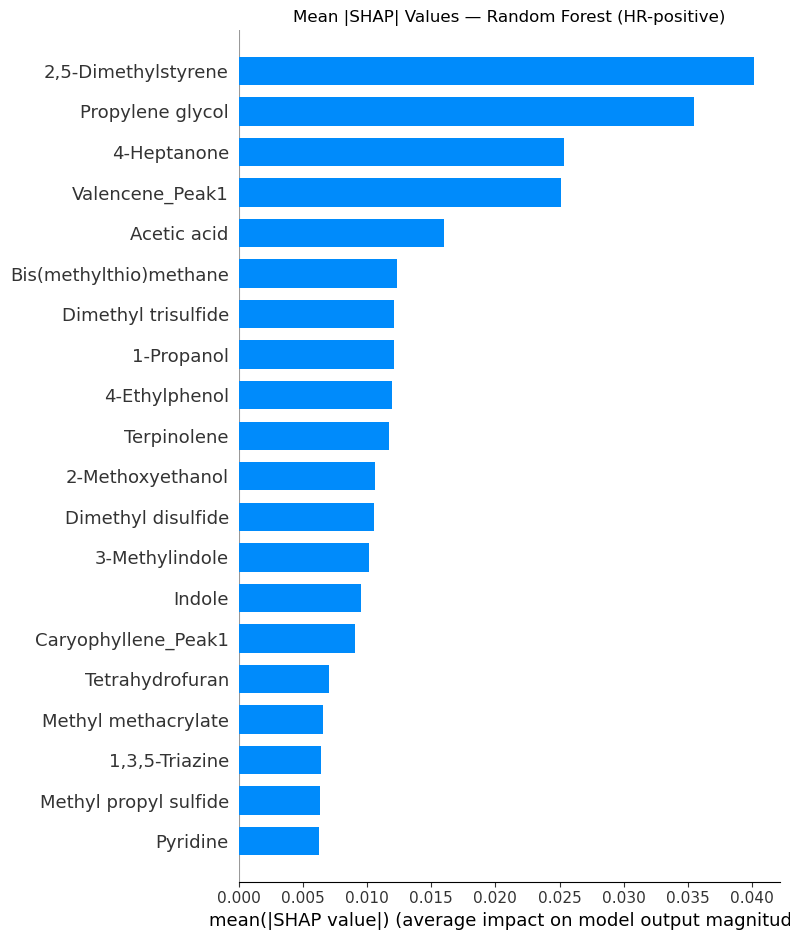


 Top 10 SHAP-important features (Random Forest):
                   Feature  Mean|SHAP|
60     2,5-Dimethylstyrene    0.040166
67        Propylene glycol    0.035463
34             4-Heptanone    0.025332
74         Valencene_Peak1    0.025108
62             Acetic acid    0.016021
54  Bis(methylthio)methane    0.012313
57     Dimethyl trisulfide    0.012130
26              1-Propanol    0.012100
84           4-Ethylphenol    0.011961
51             Terpinolene    0.011728


In [12]:
# =========================================================
# Random forest SHAP Analysis
# =========================================================
"""
Goal:
1. Use SHAP (SHapley Additive exPlanations) to interpret RF and XGBoost predictions.
2. Understand which VOCs and metadata features contribute most to predicting high-risk adenoma.
Why SHAP?
Unlike model feature importance which only tells us how imp a variable is
SHAP also tells us in what direction each feature pushes the prediction.

Outputs:
1. Global SHAP summary plot : shows how each feature influences predictions.
   (Red = increases high-risk probability, Blue = decreases)
2. Bar plot → average magnitude (|SHAP|) of each feature’s effect.
3. Ranked top SHAP-important features for reproducible reporting.
"""

# --- Reproducibility ---
np.random.seed(42)

#Prepare numeric data
# -----------------------------
X_train_for_shap = X_train_balanced.astype(float)
X_test_for_shap = X_test_combined[X_train_for_shap.columns].astype(float)

# Background sample for SHAP 
background = X_train_for_shap.sample(min(100, len(X_train_for_shap)), random_state=42)

os.makedirs("results", exist_ok=True)

#  RANDOM FOREST SHAP Analysis
print("\n Running SHAP for Random Forest...")

rf_classes = rf_model_combined.classes_
print(f"RF classes: {rf_classes}")

# Run SHAP with interventional mode
explainer_rf = shap.TreeExplainer(
    rf_model_combined,
    data=background,
    feature_perturbation="interventional"
)
shap_values_rf = explainer_rf(X_test_for_shap)

# Extract SHAP values (index 1 corresponds to class 3 = Low-risk)
values_rf = (
    shap_values_rf.values[:, :, 1]
    if shap_values_rf.values.ndim == 3
    else shap_values_rf.values
)


print("Recoding SHAP direction so positive = High-risk (class 2).")
values_rf = -values_rf  # flip sign so positive = High-risk

#SHAP summary plots
plt.figure(figsize=(10, 6))
shap.summary_plot(values_rf, X_test_for_shap, show=False)
plt.title("Global SHAP Summary — Random Forest (HR-positive)")
plt.tight_layout()
plt.show(block=False)

plt.figure(figsize=(10, 6))
shap.summary_plot(values_rf, X_test_for_shap, plot_type="bar", show=False)
plt.title("Mean |SHAP| Values — Random Forest (HR-positive)")
plt.tight_layout()
plt.show(block=False)

# SHAP importance ranking
shap_importance_rf = np.abs(values_rf).mean(axis=0)
shap_ranking_rf = pd.DataFrame({
    "Feature": X_test_for_shap.columns,
    "Mean|SHAP|": shap_importance_rf
}).sort_values(by="Mean|SHAP|", ascending=False)

shap_ranking_rf.to_csv("results/shap_importance_random_forest.csv", index=False)
print("\n Top 10 SHAP-important features (Random Forest):")
print(shap_ranking_rf.head(10))

Computing SHAP values, this might take a bit...


/var/folders/cd/2pthfxks1cv32d9l420hs0_c0000gn/T/ipykernel_2626/983163166.py:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb.values, X_test_for_shap, show=False)


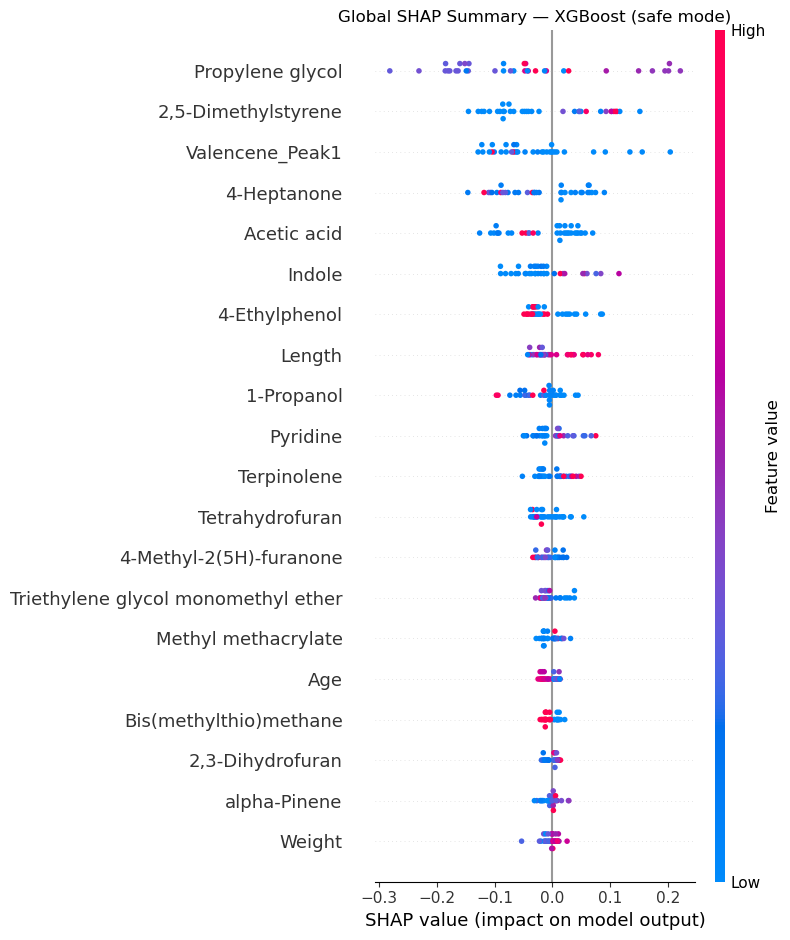

/var/folders/cd/2pthfxks1cv32d9l420hs0_c0000gn/T/ipykernel_2626/983163166.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb.values, X_test_for_shap, plot_type="bar", show=False)


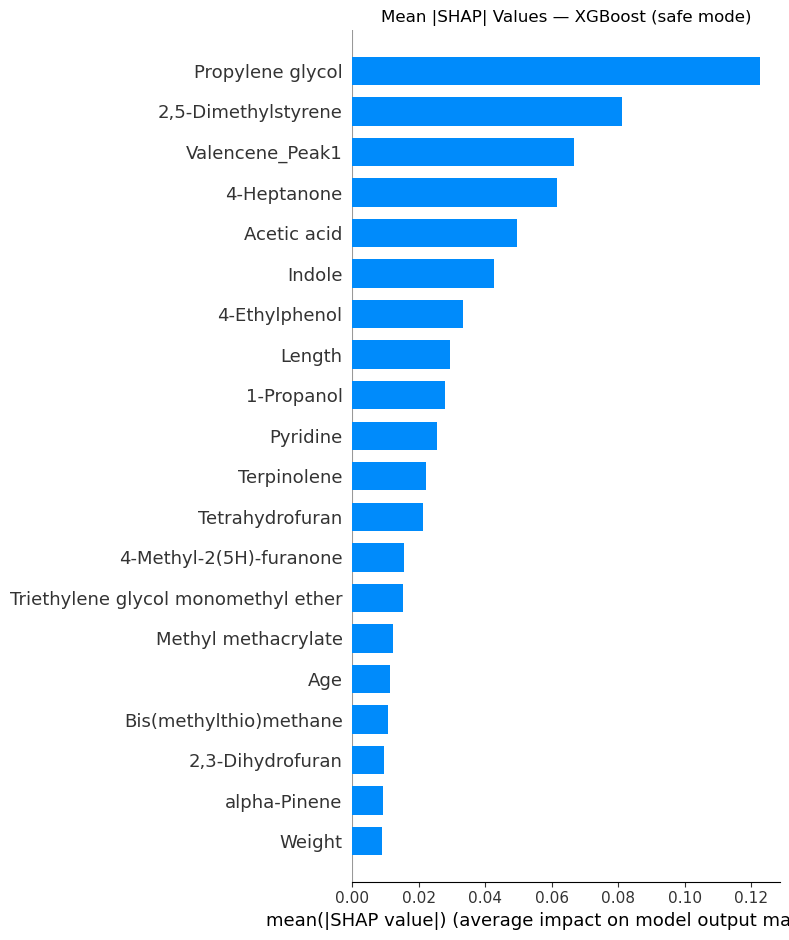


 Top 10 SHAP-important features (XGBoost):
                Feature  Mean|SHAP|
67     Propylene glycol    0.122512
60  2,5-Dimethylstyrene    0.081122
74      Valencene_Peak1    0.066710
34          4-Heptanone    0.061624
62          Acetic acid    0.049543
87               Indole    0.042556
84        4-Ethylphenol    0.033268
2                Length    0.029281
26           1-Propanol    0.027854
42             Pyridine    0.025498

 SHAP analysis complete (simple safe version). Results saved in 'results/' folder.


In [13]:
# =========================================================
# XGBOOST — SHAP Analysis 
# =========================================================
"""
Goal:
1. To interpret the XGBoost model predictions and identify which features (VOCs or metadata)
drive the classification of high-risk vs. low-risk samples.
2. Simplified setup:
    - A callable function is passed to SHAP, it basically is a way to get the prediction without having to
    "go through" the model 
    - A smaller random background sample is used to approximate feature distributions.
This makes the computation faster, more robust, and reproducible.

Outputs:
1. Global SHAP summary plot : shows how each feature influences predictions.
   (Red = increases high-risk probability, Blue = decreases)
2. Bar plot → average magnitude (|SHAP|) of each feature’s effect.
3. Ranked top SHAP-important features for reproducible reporting.
"""

# Prepare numeric data 
# Convert all predictors to float to avoid dtype issues

X_train_for_shap = X_train_balanced.astype(float)
X_test_for_shap = X_test_combined[X_train_for_shap.columns].astype(float)

#Background sample for SHAP 
# use small random subset (100) of the training data used as reference baseline
background = X_train_for_shap.sample(min(100, len(X_train_for_shap)), random_state=42)

#Force model output to be callable 
# Using predict_proba ensures SHAP can call the model directly
f = lambda X: xgb_model.predict_proba(X)[:, 1]

# Create the explainer 
explainer_xgb = shap.Explainer(f, background)

#  Compute SHAP values
print("Computing SHAP values, this might take a bit...")
shap_values_xgb = explainer_xgb(X_test_for_shap)

#Plot summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb.values, X_test_for_shap, show=False)
plt.title("Global SHAP Summary — XGBoost (safe mode)")
plt.tight_layout()
plt.show(block=False)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb.values, X_test_for_shap, plot_type="bar", show=False)
plt.title("Mean |SHAP| Values — XGBoost (safe mode)")
plt.tight_layout()
plt.show(block=False)

# Save top features
shap_importance_xgb = np.abs(shap_values_xgb.values).mean(axis=0)
shap_ranking_xgb = pd.DataFrame({
    "Feature": X_test_for_shap.columns,
    "Mean|SHAP|": shap_importance_xgb
}).sort_values(by="Mean|SHAP|", ascending=False)

shap_ranking_xgb.to_csv("results/shap_importance_xgboost_final.csv", index=False)

print("\n Top 10 SHAP-important features (XGBoost):")
print(shap_ranking_xgb.head(10))

print("\n SHAP analysis complete (simple safe version). Results saved in 'results/' folder.")


# ============================================================
# FINAL SUMMARY — SUPERVISED CLASSIFICATION RESULTS
# ============================================================
##Summary of Findings — Supervised Classification (RF + XGBoost)


###Random Forest
- Accuracy on tesr: 82.9%  
- Sensitivity/recall : HR=0.73  , LR=0.88
- Precision : HR=0.73, LR=0.88
- OOB Accuracy: 89.56%
- CV Accuracy: 89.56% ± 3.58%
- The sensitivity/specificity differences between OOB and Test suggest there is overfitting in the model which is why RF was compared to XGBoost.

###XGBoost
- Test Accuracy: 88.6%  
- Sensitivity / Recall: High-Risk = 0.73, Low-Risk = 0.96  
- Precision: High-Risk = 0.89, Low-Risk = 0.88  
- ROC AUC (Test): 0.886  
- Precision–Recall AP (Test): 0.870  
- Interpretation: Boost outperformed Random Forest on the external test set while maintaining strong recall for both risk groups.  Its sequential boosting and controlled learning rate improved generalization and reduced overfitting as can be seen with the Test accuryacy = 88.7 and Cross validation accuracy 90.65% ± 5.40%.



###Overall Insights
- Both ensemble methods identified overlapping key VOCs, strengthening their biological relevance.
- Bootstrapped upsampling effectively balanced classes and improved sensitivity to the high-risk group.
- The RF model maintained stability across OOB and CV estimates although there is slight overfitting.


